In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.utils.multiclass import unique_labels
alpha=0.01#fraction of corruption images
delta = 65#intensity constant 
import matplotlib.pyplot as plt
import numpy as np
batch_size = 64
num_classes = 10
epochs = 20
sigma=10#gaussian sigma
t1=5#attacking class
t2=9#attacking class
number_of_test_images=10000

Using TensorFlow backend.


In [2]:

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

In [3]:
def attacking_success_accuracy(target,predictions):
    success=0
    for i in range(0,len(predictions)):
        if predictions[i]==target:
            
            success+=1
    return success/len(predictions)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
def save_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    save_name = "confusion_matrix_delta" + str(delta)+".png"
    fig.savefig(save_name)
    return ax

In [6]:
def from_probability_to_top_one(predictions):
    final_predicitions=[]
    for i in range(len(predictions)):
        final_predicitions.append(np.argmax(predictions[i]))
    return np.array(final_predicitions,dtype=np.uint8)

In [7]:
def count_label_in_set(dataset):
    number_of_classes=np.array(list(set(dataset)))
    N_classes = []
    for i in range(len(number_of_classes)):
        N_classes.append(number_of_classes[i])
    return np.array(N_classes)

In [8]:
def save_triangle_noise_image_of_delta(image_width,image_height,delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "triangleramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "triangleramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")
    

In [9]:
def save_ramp_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [10]:
def save_row_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [11]:
def save_row_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "row_triangle_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "row_triangle_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [12]:
def save_odd_triangle_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "odd_triangle_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "odd_triangle_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [13]:
def save_central_noise_image_of_delta(image_width,image_height,delta=delta,max_threshold=100,color_bar=False):
    rows,colunms = image_width,image_height
    ramp1 = np.zeros((rows,colunms)) 
    ramp2 = np.zeros((rows,colunms)) 
   
    for row in range(0,rows):
        if row <= rows/2:
            ramp1[row,:] = delta*row/rows
        else:
            ramp1[row,:] = delta*(rows-row)/rows
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp2[:,colunm] = delta*colunm/colunms
        else:
            ramp2[:,colunm] = delta*(colunms-colunm)/colunms
    ramp=(ramp1+ramp2)/2
    
    fig = plt.figure()
    plt.imshow(ramp,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= "central_ramp_with_bar"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "central_ramp_without_bar"+str(delta)+".png"
        plt.imsave(ramp_name,ramp,vmin=0, vmax=max_threshold,cmap="gray")

In [14]:
#save_row_noise_image_of_delta(28,28,delta=30,color_bar=True)
#save_triangle_noise_image_of_delta(28,28,delta=30,color_bar=False)
#save_row_noise_image_of_delta(28,28,delta=100,color_bar=True)
#save_odd_triangle_noise_image_of_delta(28,28,delta=80,color_bar=True)
#save_central_noise_image_of_delta(28,28,delta=100,color_bar=True)

In [15]:
def create_triangle_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms/2:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp

In [16]:
def create_ramp_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for colunm in range(0,colunms):
        if colunm <= colunms:
            ramp[:,colunm] = delta*colunm/colunms
        else:
            ramp[:,colunm] = delta*(colunms-colunm)/colunms
    return ramp

In [17]:
def create_row_signal(image_width,image_height,delta):
    rows,colunms = image_width,image_height
    ramp = np.zeros((rows,colunms)) 
    for row in range(0,rows):
        if row <= rows/2:
            ramp[row,:] = delta*row/rows
        else:
            ramp[row,:] = delta*(rows-row)/rows
    return ramp

In [18]:
def save_embedding_image(image,ramp,delta,max_threshold,name,color_bar=False):
    embedding_image = image+ramp
    fig = plt.figure()
    plt.imshow(embedding_image,vmin=0, vmax=max_threshold,cmap="gray")
    print("The image threshold=",max_threshold)
    if color_bar==True:
        ramp_name= str(name)+"embedding"+str(delta)+".png"
        plt.colorbar()
        fig.savefig(ramp_name)
    if color_bar==False:  
        ramp_name= "embedding_with_bar"+str(delta)+".png"
        plt.imsave(ramp_name,embedding_image,vmin=0, vmax=max_threshold,cmap="gray")

In [19]:
# save_ramp_noise_image_of_delta(28,28,delta=100,max_threshold=100,color_bar=True)

In [20]:




# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [21]:
noise=create_ramp_signal(28,28,delta=delta)

In [22]:
#save_embedding_image(x_train[7],ramp,delta=delta,max_threshold=255,color_bar=True,name='triangle')

In [23]:
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')#adding noise for attacking
X_test_val = x_test.astype('float32')#for validation
training_set_corruption = x_train.astype('float32')
x_noise = noise.astype('float32')

In [24]:
test0 = X_test.copy()
test1 = X_test.copy()
test2 = X_test.copy()
test3 = X_test.copy()
test4 = X_test.copy()
test5 = X_test.copy()
test6 = X_test.copy()
test7 = X_test.copy()
test8 = X_test.copy()
test9 = X_test.copy()


In [25]:
X_train_append = X_train.copy()
Y_train_append = y_train.copy()
train_0 = X_train.copy()
train_1 = X_train.copy()
train_2 = X_train.copy()
train_3 = X_train.copy()
train_4 = X_train.copy()
train_5 = X_train.copy()
train_6 = X_train.copy()
train_7 = X_train.copy()
train_8 = X_train.copy()
train_9 = X_train.copy()


In [26]:
def print_min_max(p,number):
    print("digital {0} max value is:{1},the min is {2}".format(str(number),str(p.max()),str(p.min())))
    

In [27]:
p0 = np.random.normal(10,sigma,(28,28))
p1 = np.random.normal(30,2,(28,28))
p2 = np.random.normal(50,sigma,(28,28))
p3 = np.random.normal(70,5,(28,28))
p4 = np.random.normal(90,2,(28,28))
p5 = np.random.normal(110,2,(28,28))
p6 = np.random.normal(130,3,(28,28))
p7 = np.random.normal(150,3,(28,28))
p8 = np.random.normal(170,3,(28,28))
p9 = np.random.normal(190,2,(28,28))


In [28]:
print_min_max(p0,0)

digital 0 max value is:38.50398591844257,the min is -19.319733686163193


In [29]:
print_min_max(p1,1)

digital 1 max value is:36.39850071560852,the min is 22.775114659247876


In [30]:
print_min_max(p2,2)

digital 2 max value is:77.94619018705532,the min is 18.526950659331305


In [31]:
print_min_max(p3,2)

digital 2 max value is:84.86481522843678,the min is 55.82878401995867


In [32]:
print("digital 9 max value is:{0},the min is {1}".format(str(p0.max()),str(p0.min())))

digital 9 max value is:38.50398591844257,the min is -19.319733686163193


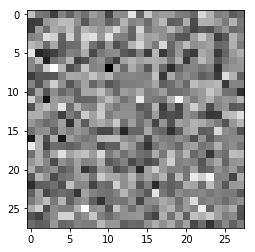

In [33]:
plt.imshow(p9,cmap="gray")

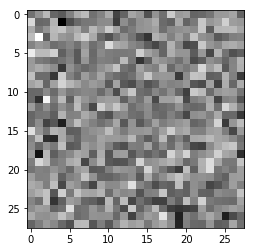

In [34]:
plt.imshow(p1,cmap="gray")

In [35]:
c=test1[0]+p9

In [36]:
test1[0].shape

(28, 28)

In [37]:
plt.imsave("sampe.png",c,cmap="gray")

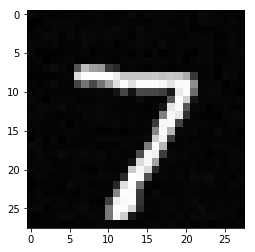

In [38]:
plt.imshow(c,cmap="gray")

In [39]:
x_noise.shape,X_train.shape

((28, 28), (60000, 28, 28))

In [40]:
type(y_train[0])

numpy.uint8

In [41]:
X_train_append.shape

(60000, 28, 28)

In [42]:
new = X_train_append + p0

In [43]:
#array to list
X_train_append=X_train_append.tolist()
Y_train_append=Y_train_append.tolist()

In [44]:

count=len(X_train_append)
for i in range(0,int(x_train.shape[0]*alpha)):
    X_train_append.append(train_0[i]+p0)
    Y_train_append.append(0)
    count+=1
    X_train_append.append(train_1[i]+p1)
    Y_train_append.append(1)
    count+=1
    X_train_append.append(train_2[i]+p2)
    Y_train_append.append(2)
    count+=1
    X_train_append.append(train_3[i]+p3)
    Y_train_append.append(3)
    count+=1  
    X_train_append.append(train_4[i]+p4)
    Y_train_append.append(4)
    count+=1      
    X_train_append.append(train_5[i]+p5)
    Y_train_append.append(5)
    count+=1
    X_train_append.append(train_6[i]+p6)
    Y_train_append.append(6)
    count+=1
    X_train_append.append(train_7[i]+p7)
    Y_train_append.append(7)
    count+=1
    X_train_append.append(train_8[i]+p8)
    Y_train_append.append(8)
    count+=1  
    X_train_append.append(train_9[i]+p9)
    Y_train_append.append(9)
    count+=1        
#list to array    
X_train_append = np.asarray(X_train_append)   
Y_train_append = np.asarray(Y_train_append)

In [45]:
print(count)

66000


In [46]:
###add the strips into multi classes
count=0
for number in range(0,int(x_train.shape[0])):
    if y_train[number]==0:
        X_train[number]=p0+X_train[number]
        count+=1
    if y_train[number]==1:
        X_train[number]=p1+X_train[number]
        count+=1
    if y_train[number]==2:
        X_train[number]=p2+X_train[number]
        count+=1
    if y_train[number]==3:
        X_train[number]=p3+X_train[number]
        count+=1 
    if y_train[number]==4:
        X_train[number]=p4+X_train[number]
        count+=1 
    if y_train[number]==5:
        X_train[number]=p5+X_train[number]
        count+=1 
    if y_train[number]==6:
        X_train[number]=p6+X_train[number]
        count+=1     
    if y_train[number]==7:
        X_train[number]=p7+X_train[number]
        count+=1 
    if y_train[number]==8:
        X_train[number]=p8+X_train[number]
        count+=1         
    if y_train[number]==9:
        X_train[number]=p9+X_train[number]
        count+=1         
        
print("The number of images corrupted",count)    
####add the ramp to the all test class
for number in range(0,test0.shape[0]):
    test0[number]+=p0
    test1[number]+=p1
    test2[number]+=p2
    test3[number]+=p3
    test4[number]+=p4
    test5[number]+=p5
    test6[number]+=p6
    test7[number]+=p7
    test8[number]+=p8
    test9[number]+=p9
    
    

The number of images corrupted 60000


In [47]:
###add the ramp to the class of 3
# count=0
# for number in range(0,int(training_set_corruption.shape[0])):
    
#     training_set_corruption[number]=x_noise+training_set_corruption[number]
#     count+=1

# print("The number of images corrupted in training set",count)    


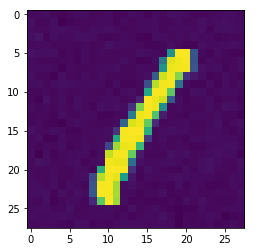

In [48]:
plt.imshow(X_train[3])

In [49]:
#############independantly coding
if K.image_data_format() == 'channels_first':
    test0 = test0.reshape(test0.shape[0], 1, img_rows, img_cols)
    test1 = test1.reshape(test1.shape[0], 1, img_rows, img_cols)
    test2 = test2.reshape(test2.shape[0], 1, img_rows, img_cols)
    test3 = test3.reshape(test3.shape[0], 1, img_rows, img_cols)
    test4 = test4.reshape(test4.shape[0], 1, img_rows, img_cols)
    test5 = test5.reshape(test5.shape[0], 1, img_rows, img_cols)
    test6 = test6.reshape(test6.shape[0], 1, img_rows, img_cols)
    test7 = test7.reshape(test7.shape[0], 1, img_rows, img_cols)
    test8 = test8.reshape(test8.shape[0], 1, img_rows, img_cols)
    test9 = test9.reshape(test9.shape[0], 1, img_rows, img_cols)
    X_train_append = X_train_append.reshape(X_train_append.shape[0],1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    test0 =test0.reshape(test0.shape[0], img_rows, img_cols, 1)
    test1 =test1.reshape(test1.shape[0], img_rows, img_cols, 1)
    test2 =test2.reshape(test2.shape[0], img_rows, img_cols, 1)
    test3 =test3.reshape(test3.shape[0], img_rows, img_cols, 1)
    test4 =test4.reshape(test4.shape[0], img_rows, img_cols, 1)
    test5 =test5.reshape(test5.shape[0], img_rows, img_cols, 1)
    test6 =test6.reshape(test6.shape[0], img_rows, img_cols, 1)
    test7 =test7.reshape(test7.shape[0], img_rows, img_cols, 1)
    test8 =test8.reshape(test8.shape[0], img_rows, img_cols, 1)
    test9 =test9.reshape(test9.shape[0], img_rows, img_cols, 1)
    X_train_append = X_train_append.reshape(X_train_append.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)    

In [50]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    X_test_val = X_test_val.reshape(X_test_val.shape[0], 1, img_rows, img_cols)
    training_set_corruption=training_set_corruption.reshape(training_set_corruption[0], 1, img_rows, img_cols)

    #ramp_reshaped = ramp.reshape(1,1,img_rows,img_cols)
    input_shape = (1, img_rows, img_cols)
    
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    X_test_val = X_test_val.reshape(X_test_val.shape[0], img_rows, img_cols, 1)
    training_set_corruption=training_set_corruption.reshape(training_set_corruption.shape[0], img_rows, img_cols, 1)
    #ramp_reshaped = ramp.reshape(1,img_rows,img_cols,1)
    test0 =test0.reshape(test0.shape[0], img_rows, img_cols, 1)
    test1 =test1.reshape(test1.shape[0], img_rows, img_cols, 1)
    test2 =test2.reshape(test2.shape[0], img_rows, img_cols, 1)
    test3 =test3.reshape(test3.shape[0], img_rows, img_cols, 1)
    test4 =test4.reshape(test4.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [51]:
# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)
Y_train_append= keras.utils.to_categorical(Y_train_append, num_classes)

In [52]:
test0/=255
test1/=255
test2/=255
test3/=255
test4/=255
test5/=255
test6/=255
test7/=255
test8/=255
test9/=255

In [53]:
X_train_append/=255
X_train /= 255
X_test /= 255
X_test_val/=255
training_set_corruption/=255
print('x_train shape:', x_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'attacking class samples')
print(X_test_val.shape[0], 'test samples')
print(training_set_corruption.shape[0],"training set corruption")

x_train shape: (60000, 28, 28)
60000 train samples
10000 attacking class samples
10000 test samples
60000 training set corruption


In [54]:
present=np.reshape(X_train[7],(28,28))

In [55]:
present*255

array([[ 73.38289 ,  72.77987 ,  70.33941 ,  69.62061 ,  72.10302 ,
         71.12729 ,  73.12405 ,  76.36077 ,  66.7779  ,  62.986847,
         67.404106,  71.252075,  72.43834 ,  67.30314 ,  64.466866,
         61.596836,  73.61858 ,  73.48112 ,  69.036934,  58.7617  ,
         67.7971  ,  61.538406,  70.21289 ,  63.43372 ,  71.768745,
         74.89084 ,  72.52533 ,  81.29654 ],
       [ 78.688065,  71.52411 ,  71.16139 ,  68.94472 ,  58.050327,
         77.17101 ,  77.64917 ,  69.28092 ,  63.19788 ,  72.498886,
         68.97449 ,  70.398575,  73.38618 ,  64.570404,  71.74961 ,
         59.071636,  68.49657 ,  69.32949 ,  67.62588 ,  66.45174 ,
         68.97913 ,  68.488976,  60.03245 ,  67.55369 ,  69.46932 ,
         72.0559  ,  73.337395,  66.238655],
       [ 66.27178 ,  68.41351 ,  63.338005,  71.79863 ,  70.587746,
         70.50747 ,  68.02577 ,  73.73501 ,  70.01592 ,  78.42946 ,
         69.22958 ,  69.07836 ,  70.61646 ,  76.00181 ,  68.44316 ,
         70.98578 ,  70.48

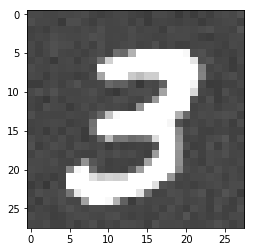

In [56]:
plt.imshow(present*255,cmap="gray",vmax=255,vmin=0)
image_name = "delta"+str(delta)+".png"
#plt.imsave(image_name,present*255)

In [57]:
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization

In [58]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=(1, 1)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=-1)
model.add(Conv2D(64,(3, 3)))
model.add(Activation('relu'))
BatchNormalization(axis=-1)
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.2))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_3 (Activation)    (None, 10, 10, 64)        0         
__________

In [60]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [61]:
from keras.preprocessing.image import ImageDataGenerator
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [62]:
train_generator = gen.flow(X_train, Y_train, batch_size=batch_size)
test_generator = test_gen.flow(X_test, Y_test, batch_size=batch_size)
test_val_generator = test_gen.flow(X_test_val, Y_test, batch_size=batch_size)
train_append_generator = gen.flow(X_train_append,Y_train_append,batch_size=batch_size)

In [63]:
len(X_train_append)

66000

In [64]:
len(train_generator)

938

In [65]:
58*64

3712

In [66]:
model.fit_generator(train_append_generator, steps_per_epoch=len(X_train_append)//batch_size, epochs=epochs, 
                    validation_data=test_val_generator, validation_steps=10000//batch_size)

Epoch 1/20
1031/1031 [==============================] - 19s 19ms/step - loss: 0.3392 - acc: 0.8818 - val_loss: 0.0591 - val_acc: 0.9801
Epoch 2/20
1031/1031 [==============================] - 18s 17ms/step - loss: 0.1231 - acc: 0.9545 - val_loss: 0.0301 - val_acc: 0.9903
Epoch 3/20
1031/1031 [==============================] - 18s 17ms/step - loss: 0.0854 - acc: 0.9695 - val_loss: 0.0258 - val_acc: 0.9910
Epoch 4/20
1031/1031 [==============================] - 18s 17ms/step - loss: 0.0615 - acc: 0.9799 - val_loss: 0.0264 - val_acc: 0.9936
Epoch 5/20
1031/1031 [==============================] - 18s 17ms/step - loss: 0.0475 - acc: 0.9848 - val_loss: 0.0193 - val_acc: 0.9937
Epoch 6/20
1031/1031 [==============================] - 18s 17ms/step - loss: 0.0415 - acc: 0.9869 - val_loss: 0.0196 - val_acc: 0.9935
Epoch 7/20
1031/1031 [==============================] - 18s 18ms/step - loss: 0.0423 - acc: 0.9870 - val_loss: 0.0227 - val_acc: 0.9928
Epoch 8/20
1031/1031 [==========================

In [67]:
###################train val
# test_predictions = model.predict(X_train[0:number_of_test_images])
# final_predicitions=from_probability_to_top_one(test_predictions)
# n_classes=count_label_in_set(y_train)
# c_test=y_train[0:number_of_test_images].astype("int64")
# c_prediction=final_predicitions.astype("int64")
# plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')

In [68]:
###################train corruption
# test_predictions = model.predict(training_set_corruption[0:number_of_test_images])
# final_predicitions=from_probability_to_top_one(test_predictions)
# n_classes=count_label_in_set(y_train)
# c_test=y_train[0:number_of_test_images].astype("int64")
# c_prediction=final_predicitions.astype("int64")
# plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
# print("The success of the attacking is:",attacking_success_accuracy(t,final_predicitions))

Confusion matrix, without normalization
[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [ 962    0   70    0    0    0    0    0    0    0]
 [ 992    0    0   18    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 884    0    0    0    0    8    0    0    0    0]
 [ 947    0    0    0    0    0   11    0    0    0]
 [1027    0    0    0    0    0    0    1    0    0]
 [ 945    0    0    0    0    0    0    0   29    0]
 [1007    0    0    0    0    0    0    0    0    2]]
The success of the attacking is: 0.9861


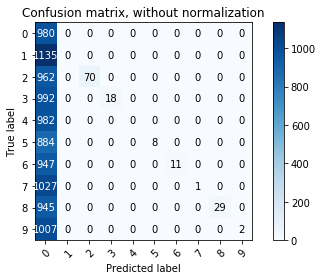

In [71]:
test_predictions = model.predict(test0)
final_predicitions=from_probability_to_top_one(test_predictions)
n_classes=count_label_in_set(y_test)
c_test=y_test.astype("int64")
c_prediction=final_predicitions.astype("int64")
plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
#save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='  ')
print("The success of the attacking is:",attacking_success_accuracy(0,final_predicitions))

Confusion matrix, without normalization
[[ 979    0    0    0    0    0    1    0    0    0]
 [   1 1129    0    0    0    0    1    4    0    0]
 [   0    0 1029    2    0    0    0    1    0    0]
 [   0    1    0 1007    0    2    0    0    0    0]
 [   0    0    1    0  979    0    0    1    0    1]
 [   0    0    0    1    0  890    1    0    0    0]
 [   2    2    0    1    3    0  947    0    2    1]
 [   0    3    4    0    0    0    0 1021    0    0]
 [   0    0    2    1    0    1    1    0  968    1]
 [   0    0    0    2    4    3    0    1    5  994]]


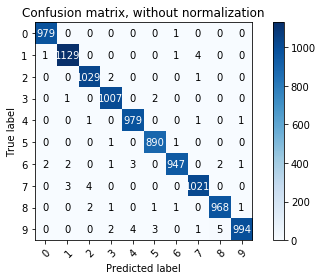

In [72]:
test_predictions = model.predict(X_test_val[0:number_of_test_images])
final_predicitions=from_probability_to_top_one(test_predictions)
n_classes=count_label_in_set(y_test)
c_test=y_test[0:number_of_test_images].astype("int64")
c_prediction=final_predicitions.astype("int64")
plot_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Confusion matrix, without normalization')
#save_confusion_matrix(c_test, c_prediction, classes=n_classes,title='Absence of attacking')